# rapidity fits

In [1]:
import sys,os
os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
from matplotlib.colors import LogNorm
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from fitlab.resman import RESMAN
import fitlab.nest

In [2]:
conf=load_config('inputs/upol.py')
resman=RESMAN(conf)
parman=resman.conf['parman']

loading sidis data sets 1005

In [3]:
res=resman.get_residuals(parman.par)

In [4]:
tabs=resman.sidisres.tabs
yp,yh,dy=[],[],[]
for k in tabs: yh.extend(tabs[k]['yh'])
for k in tabs: dy.extend(tabs[k]['dy'])
for k in tabs: yp.extend(tabs[k]['yp'])

In [5]:
print np.amin(yp),np.amax(yp)
print np.amin(yh),np.amax(yh)

2.08052279917 2.71757321844
-1.87761758075 1.55997387013


(0, 4.0985187462178549)

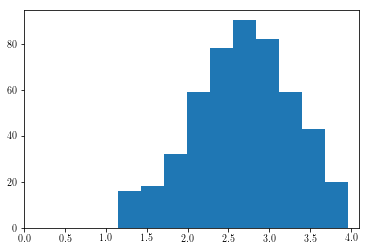

In [6]:
ax=py.subplot(111)
ax.hist(dy)
ax.set_xlim(0,None)

In [36]:
PAR=load('maxlike/rap_fits.dat')

In [37]:
PAR

{1.5: array([ 0.56289338,  0.58057805,  0.14028143,  0.11930116]),
 2.0: array([ 0.52840254,  0.49365696,  0.14856939,  0.12488323]),
 2.5: array([ 0.43923215,  0.41271125,  0.1517873 ,  0.1474689 ]),
 3.0: array([ 0.33993636,  0.25285457,  0.15302982,  0.16912197]),
 3.5: array([ 0.2670366 ,  0.3766198 ,  0.15594102,  0.19038116])}

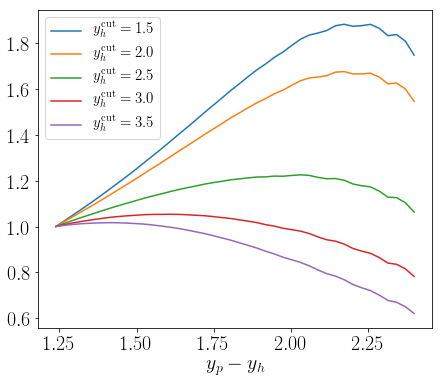

In [9]:
def get_xsec(par,dy,W2,Q2,pT):
    
    conf['parman'].set_new_params(par)
    
    FUU=lambda x,z,Q2,pT: conf['sidis stfuncs'].get_FX(1,x,z,Q2,pT,'p','pi+')
    
    
    M=conf['aux'].M
    M2=conf['aux'].M**2
    Mh=conf['aux'].Mpi
    MhT=np.sqrt(Mh**2+pT**2)
    x=Q2/(W2+Q2-M2)

    E=27.6
    y=Q2/(2*M*E*x)
    
    norm=1/x/y/Q2*(1-y+0.5*y**2)

    
    xn=2*x/(1+np.sqrt(1+4*x**2*M2/Q2))

    p0=3
    p1=p0
    p2=10
    
    
    z0=xn*MhT*M/(Q2-xn**2*M2)*(np.exp(p0)+np.exp(-p0))
    FUU0 = FUU(x,z0,Q2,pT)*np.sinh(p0)
    J0=Q2*MhT*M*2*np.sinh(p0)/(W2+Q2)**3
    
    z=xn*MhT*M/(Q2-xn**2*M2)*(np.exp(dy)+np.exp(-dy))
    R=(1+np.tanh(p2*(dy-p1)))/2
    W2=M2+Q2*(1-x)/x
    J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
    xsec=norm*FUU(x,z,Q2,pT)*J #* R + (1-R)*(FUU0*J0)

    #if x<1e-3 or x>0.6: xsec=0
    #if z<0.0001 or z>0.6: xsec=0
    if z<0.2 or z>0.6: xsec=0

    return xsec
    


tabs=resman.sidisres.tabs
yp,yh,dy=[],[],[]
for k in tabs: yh.extend(tabs[k]['yh'])
for k in tabs: dy.extend(tabs[k]['dy'])
for k in tabs: yp.extend(tabs[k]['yp'])

nrows,ncols=2,2
py.figure(figsize=(ncols*6,nrows*5))


ax=py.subplot(nrows,ncols,1)
W2=10
Q2=5
pT=0.8
dy=np.linspace(np.amin(dy),np.amax(dy),100)
for k in sorted(PAR):
    xsec=[get_xsec(PAR[k],_dy,W2,Q2,pT) for _dy in dy]
    I=[i for i in range(len(xsec)) if xsec[i]>0]
    xsec=np.array([xsec[i] for i in I])
    xsec_max=1#np.amax(xsec)
    dy=[dy[i] for i in I]
    ax.plot(dy,xsec/xsec[0],label=r'$y_h^{\rm cut}=%0.1f$'%k)
ax.legend(fontsize=15)
ax.set_xlabel(r'$y_p-y_h$',size=20)
ax.tick_params(axis='both', which='major', labelsize=20)
#ax.set_ylim(0,0.005)

py.tight_layout()

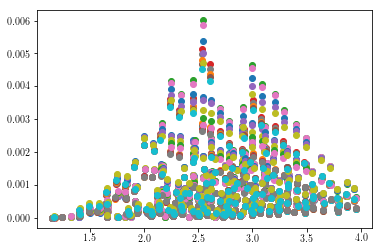

In [24]:
def plot(ax,par):
    tabs=resman.sidisres.tabs
    conf['parman'].set_new_params(par)
    
    for k in tabs:
        yp=tabs[k]['yp']
        yh=tabs[k]['yh']
        x=tabs[k]['x']
        z=tabs[k]['z']
        Q2=tabs[k]['Q2']
        pT=tabs[k]['pT']
        hadron=tabs[k]['hadron'][0]
        target=tabs[k]['target'][0]

        if target=='proton':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])
        if target=='deuteron':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])+\
                  np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'n',hadron) for i in range(x.size)])
  
        dy=yp-yh    
        M=conf['aux'].M
        M2=conf['aux'].M**2
        Mh=conf['aux'].Mpi
        MhT=np.sqrt(Mh**2+pT**2)
        W2=M2+Q2*(1-x)/x
        J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
        ax.plot(dy,FUU*J,'o')

ax=py.subplot(111)
dy=np.linspace(0,5,100)
for k in sorted(PAR): plot(ax,PAR[k])
#ax.set_ylim(0,0.003)


In [ ]:
def plot(ax,par):
    tabs=resman.sidisres.tabs
    conf['parman'].set_new_params(par)
    
    for k in tabs:
        yp=tabs[k]['yp']
        yh=tabs[k]['yh']
        x=tabs[k]['x']
        z=tabs[k]['z']
        Q2=tabs[k]['Q2']
        pT=tabs[k]['pT']
        hadron=tabs[k]['hadron'][0]
        target=tabs[k]['target'][0]

        if target=='proton':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])
        if target=='deuteron':
            FUU = np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'p',hadron) for i in range(x.size)])+\
                  np.array([conf['sidis stfuncs'].get_FX(1,x[i],z[i],Q2[i],pT[i],'n',hadron) for i in range(x.size)])
  
        dy=yp-yh    
        M=conf['aux'].M
        M2=conf['aux'].M**2
        Mh=conf['aux'].Mpi
        MhT=np.sqrt(Mh**2+pT**2)
        W2=M2+Q2*(1-x)/x
        J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
        ax.plot(dy,FUU*J,'o')

ax=py.subplot(111)
dy=np.linspace(0,5,100)
for k in sorted(PAR): plot(ax,PAR[k])
#ax.set_ylim(0,0.003)


In [7]:
data=pd.concat([pd.DataFrame(tabs[k]) for k in tabs])

In [29]:
def plot_kin(data):
    nrows,ncols=2,2
    py.figure(figsize=(ncols*5,nrows*3))
    ax=py.subplot(nrows,ncols,1)
    ax.hist(data['W2'],bins=100);ax.set_xlabel(r'$W^2$');ax.set_xlim(14,18.5)
    ax=py.subplot(nrows,ncols,2)
    ax.hist(data['pT'],bins=100);ax.set_xlabel(r'$p_T$');ax.set_xlim(0.15,0.95)
    ax=py.subplot(nrows,ncols,3)
    ax.hist(data['Q2'],bins=100);ax.set_xlabel(r'$Q^2$');ax.set_xlim(1.5,9.5)
    ax=py.subplot(nrows,ncols,4)
    ax.hist(data['z'],bins=100);ax.set_xlabel(r'$z$');ax.set_xlim(0.1,0.55)
    py.tight_layout()

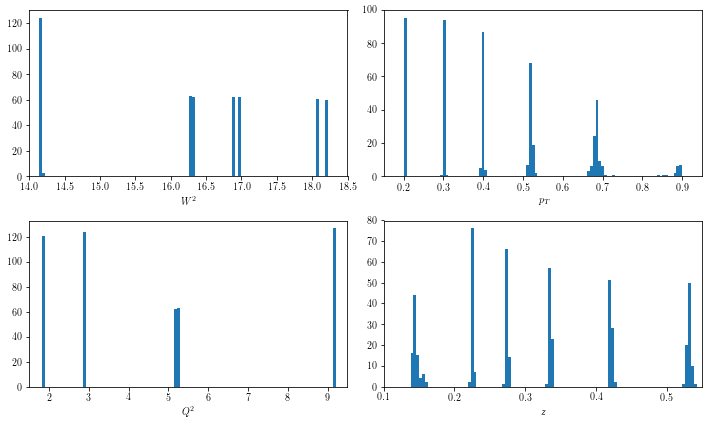

In [30]:
plot_kin(data)

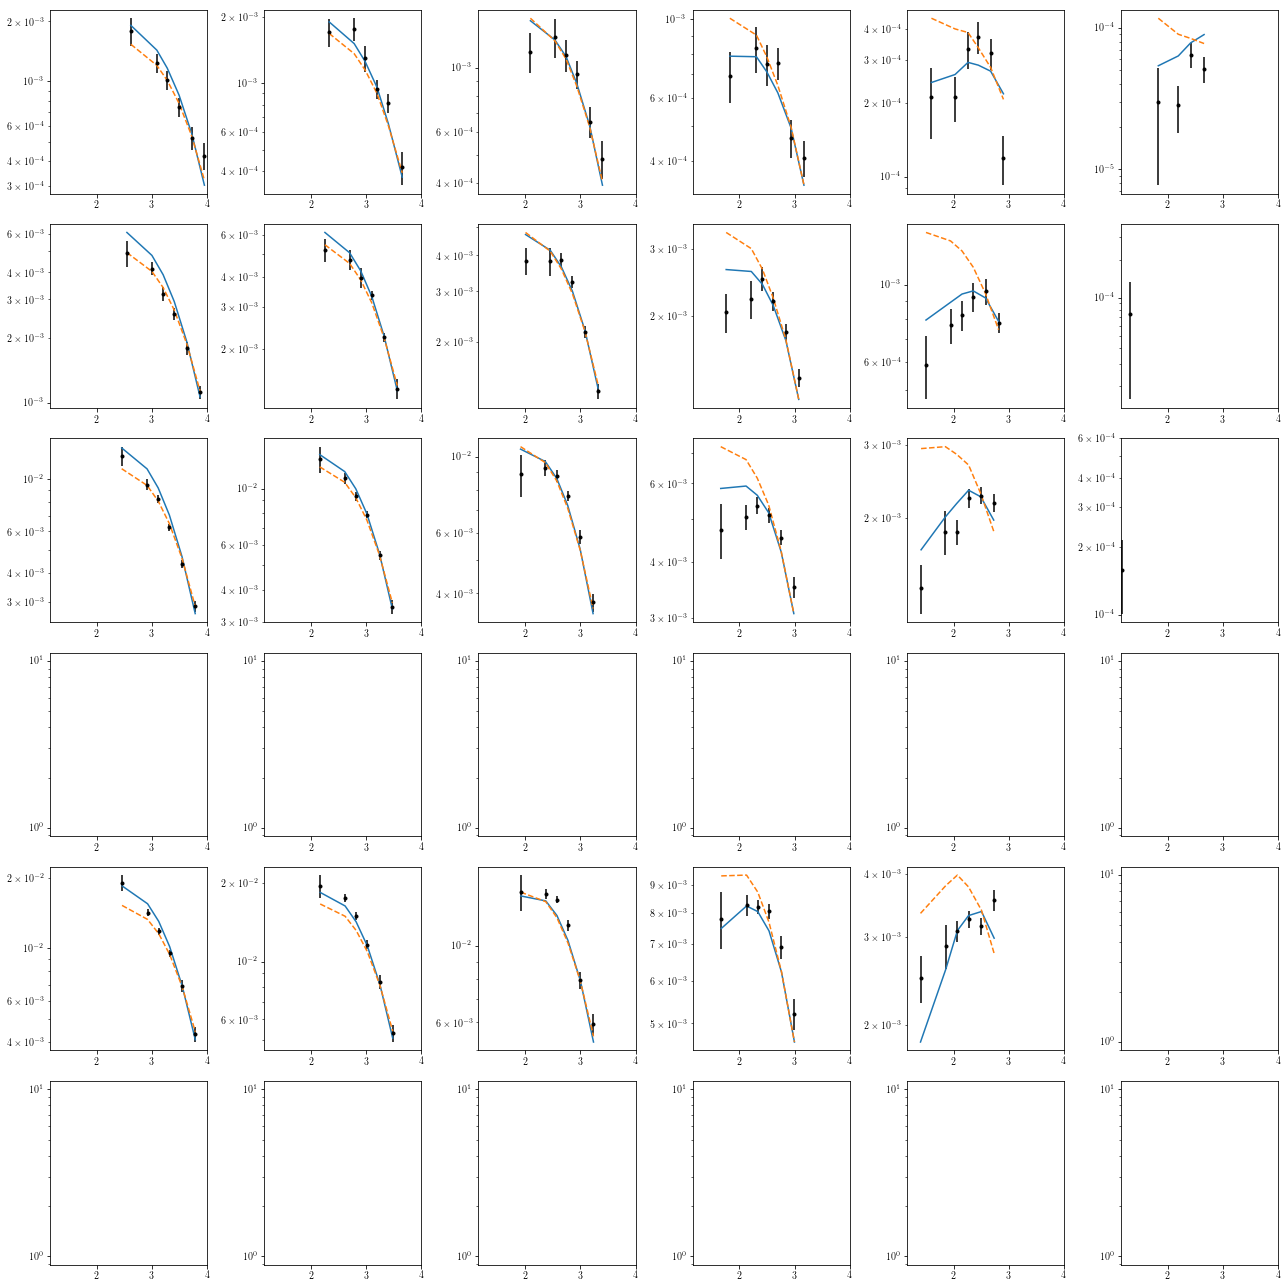

In [43]:
p0=np.copy(conf['parman'].par)    
def get_sample(pTmin,pTmax,W2min,W2max):
    d=data.query("target=='proton'").query("hadron=='pi+'")
    d=d.query('W2>%f and W2<%f'%(W2min,W2max))
    d=d.query('pT>%f and pT<%f'%(pTmin,pTmax))

    FUU=lambda x,z,Q2,pT: conf['sidis stfuncs'].get_FX(1,x,z,Q2,pT,'p','pi+')
    pT=d['pT']
    M=conf['aux'].M
    M2=conf['aux'].M**2
    Mh=conf['aux'].Mpi
    MhT=np.sqrt(Mh**2+pT**2)

    E=27.6
    x=d['x']
    z=d['z']
    Q2=d['Q2']
    y=Q2/(2*M*E*x)
    norm=1/x/y/Q2*(1-y+0.5*y**2)
    dy=d['yp']-d['yh']

    xn=2*x/(1+np.sqrt(1+4*x**2*M2/Q2))
    W2=d['W2']
    J=Q2*MhT*M*2*np.sinh(dy)/(W2+Q2)**3
    mult=d['value']
    alpha=d['alpha']
    F2=np.array([conf['dis stfuncs'].get_F2(x.values[i],Q2.values[i],'proton') for i in range(x.size)])
    xsec1=norm*mult*F2*J 
    dxsec1=norm*alpha*F2*J
    
    conf['parman'].set_new_params(p0)
    FUU2=np.array([FUU(x.values[i],z.values[i],Q2.values[i],pT.values[i]) for i in range(x.size)])
    xsec2=norm*FUU2*J * 2*np.pi*pT

    conf['parman'].set_new_params(PAR[3.0])
    FUU3=np.array([FUU(x.values[i],z.values[i],Q2.values[i],pT.values[i]) for i in range(x.size)])
    xsec3=norm*FUU3*J * 2*np.pi*pT
    
    return dy,xsec1,dxsec1,xsec2,xsec3

nrows,ncols=6,6
py.figure(figsize=(ncols*3,nrows*3))

W2=[[14,15],[16,16.5],[16.5,16.95],[16.95,17],[18,18.15],[18.15,18.25]]
pT=[[0.15,0.25],[0.25,0.35],[0.35,0.45],[0.5,0.55],[0.65,0.75],[0.85,0.95]]
cnt=0
for ii in range(len(W2)):
    for jj in range(len(pT)):
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        dy,xsec1,dxsec1,xsec2,xsec3=get_sample(pT[jj][0],pT[jj][1],W2[ii][0],W2[ii][1])
        #if i!=5: continue 
        #print xsec1.values,dxsec1.values,xsec2.values,dy
        ax.errorbar(dy,xsec1,yerr=dxsec1,fmt='k.')
        ax.plot(dy,xsec2,'-')
        ax.plot(dy,xsec3,'--')
        ax.semilogy()
        ax.set_xlim(1.15,4)

py.tight_layout()